In [55]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,opts,sz_o = args['h0'],args['h'],args['times'],args['opts'], args['sz_o']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_o], args = params)
    return out.expect

def run_dynam_states(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,opts = args['h0'],args['h'],args['times'],args['opts']
    rho0 = args['rho0']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]    
    out = mesolve(H, rho0, times, [], [], args = params, progress_bar=None)
    return out.expect

def entvn(t, rho):
    '''
        For each N please check this part.
        It has to handle manually.
    '''
    
    N,N1 = 8, 4
    N2 = N-N1
    
    rho = Qobj(rho.full(), dims = [[2**N1,2**N2],[2**N1, 2**N2]])
    rho_b =  rho.ptrace(1)
    return entropy_vn(rho_b)


def run_ent_von(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,opts = args['h0'],args['h'],args['times'],args['opts']
    rho = args['rho0']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]    
    out = mesolve(H, rho, times, [], entvn, args = params, progress_bar=True)
    return out.expect

##-------- Von Neuman Entropy with partial trace-----------
def partial_vn_entropy(args, rho):
    N,N1 = args['N'],args['N1']
    N2 = N-N1
    rho = Qobj(rho.full(), dims = [[2**N1,2**N2],[2**N1, 2**N2]])
    rho_b =  rho.ptrace(1)
    return entropy_vn(rho_b)

##--------Floquet Dynamics-------------------------------
def run_floquet(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,opts = args['h0'],args['h'],args['opts']
    params = args    
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1,lambd_x,lambd_y,Jvalue,beta,g,ea,eb)
    H = [[H11,drive1], [H12,drive1], [H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    T = 2*np.pi/w  * 2
    f_modes_0, f_energies = floquet_modes(H,T, params)
    return f_energies

print("Function definition complete!!")

Function definition complete!!


In [ ]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
import h5py
#from funcs_multiprocess import *

freezing_pts = jn_zeros(0, 5)

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 200 * T, 2001, endpoint=True)
'''
tms = np.exp(np.linspace(0, 50 * T, 51, endpoint=True, dtype='float128'))

ns = []
for t,tt in enumerate(tms):
    idx, = np.where(np.isclose(np.exp(times, dtype='float128'), tt))
    ns.append(idx[0])
ns = np.array(ns)
'''

ea, eb = 0.03, 0.9
lambd_y = 0
lambd_x = 0

ft = 10    # fintsize
g = np.pi/T
betas = [0.0, 1.5, 2.5, float('inf')]   
jvalues = [0.072/T, 0.2/T]

nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4, num_cpus=1, openmp_threads=1)

spinposition_A = [0,1,2,3]
spinposition_B = [4,5,6,7] 

h0 = 0.0
h = freezing_pts[0] * w/4 
#h = 6.0 * w/4

sx,sy,sz = sigmax(), sigmay(), sigmaz()

psi0 = basis(2**N,0)
rho0 = psi0 * psi0.dag()

for Jvalue in tqdm(jvalues):
    dt = []
    params = [{'h0':0.0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
               'opts':opts,'lambd_x':lambd_x,'rho0':rho0,\
               'lambd_y':lambd_y, 'Jvalue':Jvalue,'beta':beta,\
               'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]
    data_full = p.map(run_ent_von, params)
    
    for b in range(len(betas)):        
        fname = "ee_long_time_"+str(N)+"_j_"+str(Jvalue)+"_beta_"+str(betas[b])+"_.hdf5"
        with h5py.File(fname, 'w') as hf:
            ent = hf.create_dataset('ent', np.shape(data_full[b]), data=data_full[b])
            timx = hf.create_dataset('timx', np.shape(times), data=times)
            hf.attrs['N'] = N  
            hf.attrs['Jvalue'] = Jvalue
            hf.attrs['beta'] = betas[b]
    
print('run complete !')

In [1]:
!ls ee_long_time_8*>files.txt

In [2]:
cat files.txt

ee_long_time_8_j_0.22918311805232927_beta_0.0_.hdf5
ee_long_time_8_j_0.22918311805232927_beta_1.5_.hdf5
ee_long_time_8_j_0.22918311805232927_beta_2.5_.hdf5
ee_long_time_8_j_0.22918311805232927_beta_inf_.hdf5
ee_long_time_8_j_0.6366197723675814_beta_0.0_.hdf5
ee_long_time_8_j_0.6366197723675814_beta_1.5_.hdf5
ee_long_time_8_j_0.6366197723675814_beta_2.5_.hdf5
ee_long_time_8_j_0.6366197723675814_beta_inf_.hdf5


m= 0  beta= 0.0
m= 0  beta= 1.5
m= 0  beta= 2.5
m= 0  beta= inf
m= 1  beta= 0.0
m= 1  beta= 1.5
m= 1  beta= 2.5
m= 1  beta= inf


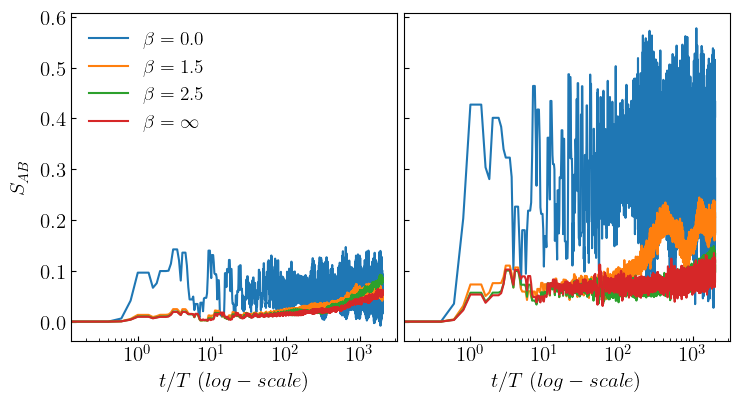

In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

plt.rcParams.update({"figure.figsize": (8.5, 4.25),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

w = 20
T = 2 * np.pi/w
jvalues = [0.2/T, 0.072/T]

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.02, hspace=0.1)

with open("files.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, "r") as f:
            data = f['ent'][()]
            times = f['timx'][()]
            N = f.attrs['N']
            Jvalue = f.attrs['Jvalue']
            beta = f.attrs['beta']
            
            if Jvalue == jvalues[0]:
                m = 1
            else:
                m = 0
            print('m=',m,' beta=',beta)
            
            N1 = int(N/2)
            
            if beta > 4:
                axs[m].plot(times/T, data, label=fr'$\beta=\infty$')
            else:
                axs[m].plot(times/T, data, label=fr'$\beta={beta:1.1f}$')
                
            axs[m].set_xlabel(r"$t/T$  $(log-scale)$")
            
            #axs[m].ylim(-0.001, 0.007)
            #axs[m].set_yscale('log')
            axs[m].set_xscale('log')
            axs[m].tick_params(which='both',axis="x", direction="in")
            axs[m].tick_params(which='both',axis="y", direction="in")
            
            #axs[m].axhline(y=0.0, color='black', linestyle='--')

axs[0].set_ylabel(r"$S_{AB}$", labelpad=8) 
#axs[1].yaxis.tick_right()
axs[0].legend(frameon=False, loc=2, fontsize=14)


#plt.savefig('entangEntrp.pdf', bbox_inches='tight', pad_inches=0.0, dpi = 600)
plt.show()